Загружено файлов: 2499
Уникальных говорящих: 49

Извлечение признаков из аудиофайлов...


100%|██████████| 2499/2499 [10:41<00:00,  3.90it/s]



Извлечено признаков: (2499, 54)
Количество записей: 2499
Уникальных говорящих: 49

Примеры извлеченных признаков:
   mfcc_0_mean  mfcc_1_mean  mfcc_2_mean  mfcc_3_mean  mfcc_4_mean  \
0  -357.332520    63.855858    11.602688    16.230892     5.837962   
1  -334.750305    72.051826     9.320847    18.901123     7.919407   
2  -351.699066    63.194202    10.281833    20.712955     6.990758   
3  -342.653015    71.996498     7.330736    20.933001     7.288354   
4  -351.414368    72.693443    10.232086    20.251766     5.925547   

   mfcc_5_mean  mfcc_6_mean  mfcc_7_mean  mfcc_8_mean  mfcc_9_mean  ...  \
0    -3.313705   -20.852589   -15.193174   -10.088342   -13.398648  ...   
1    -4.412713   -23.238867   -15.227791   -12.895134   -13.948693  ...   
2    -3.047773   -22.945665   -15.498153   -10.736275   -14.278643  ...   
3    -3.916387   -23.161842   -13.298981   -10.315767   -14.037600  ...   
4    -3.842334   -21.185923   -14.680667   -12.022346   -14.131197  ...   

   chroma_G#_

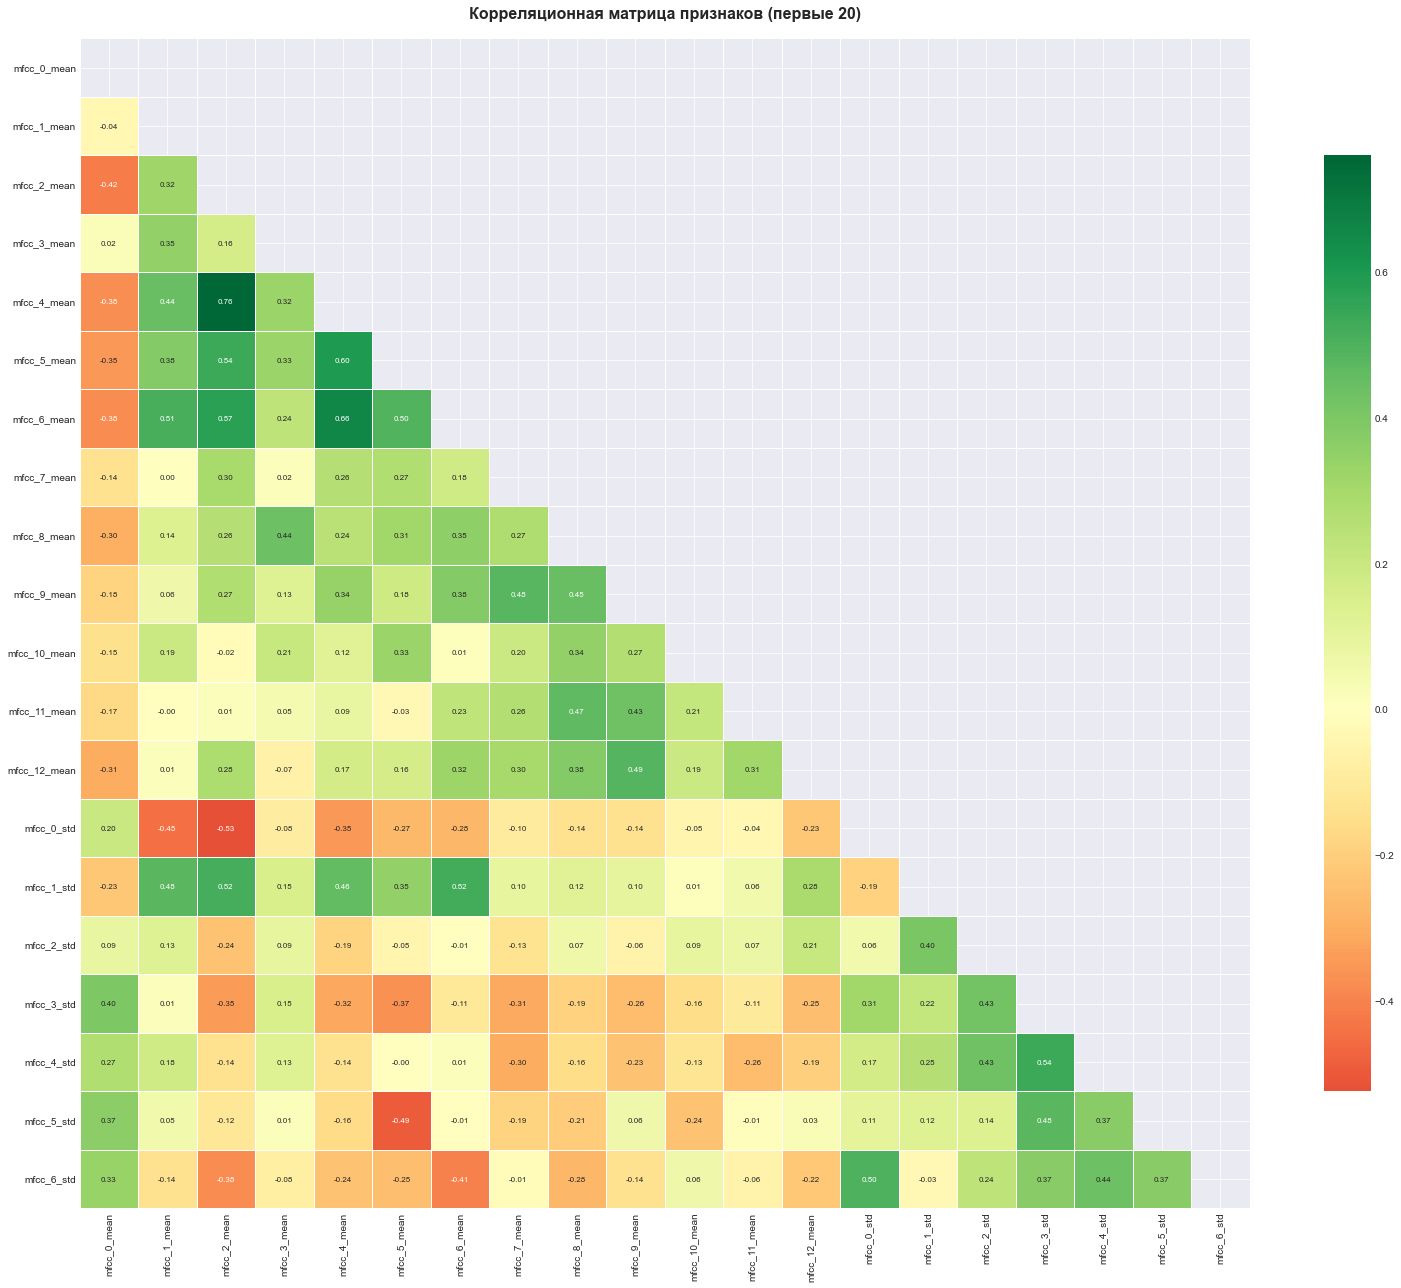

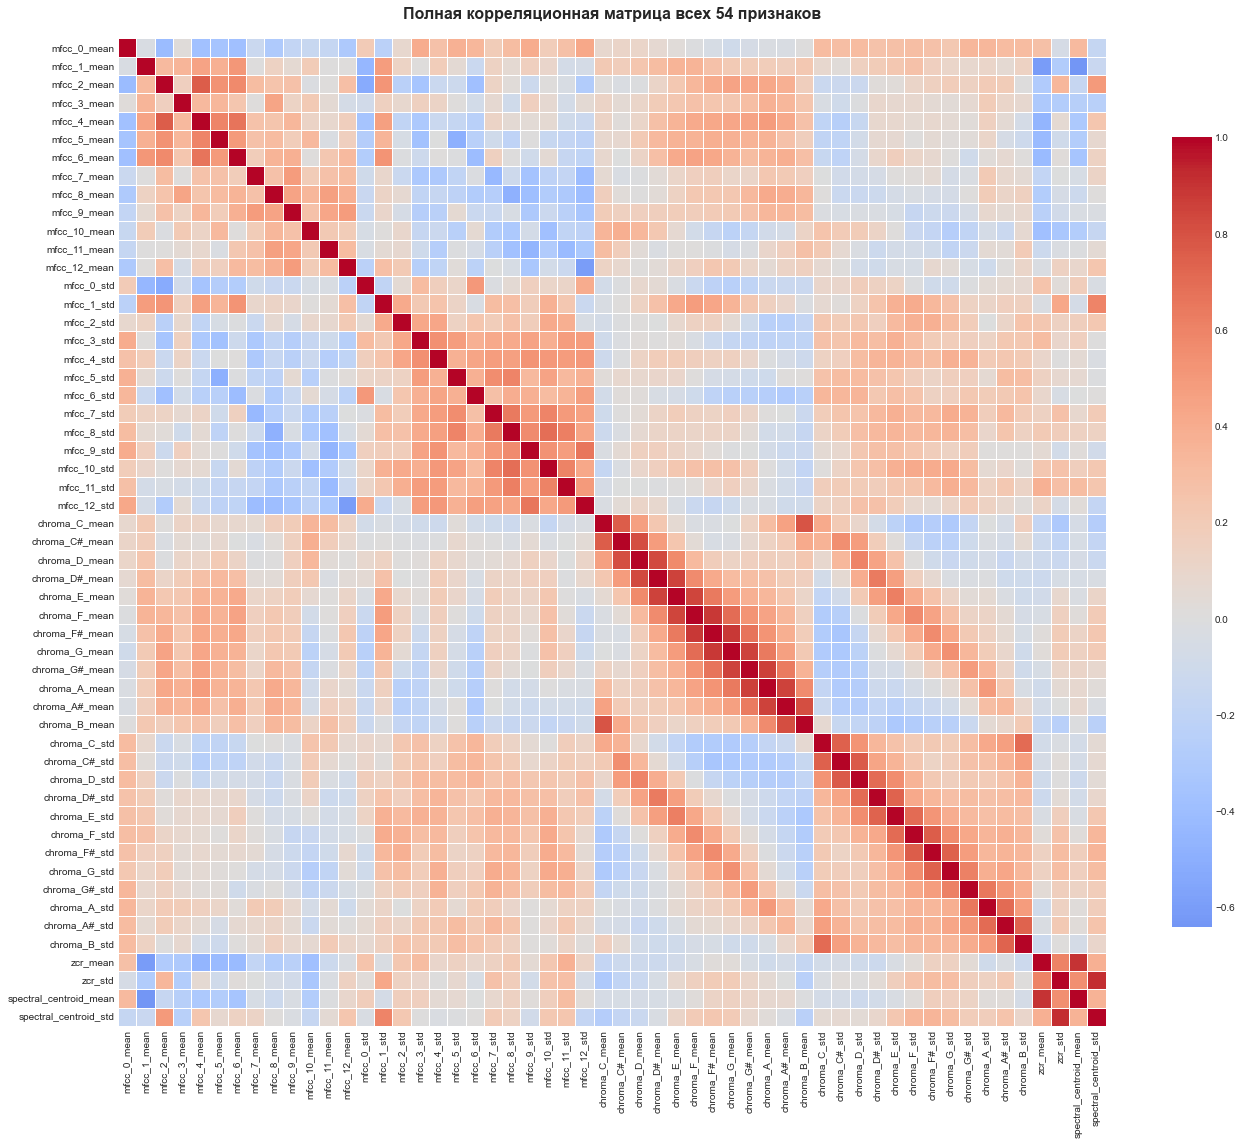

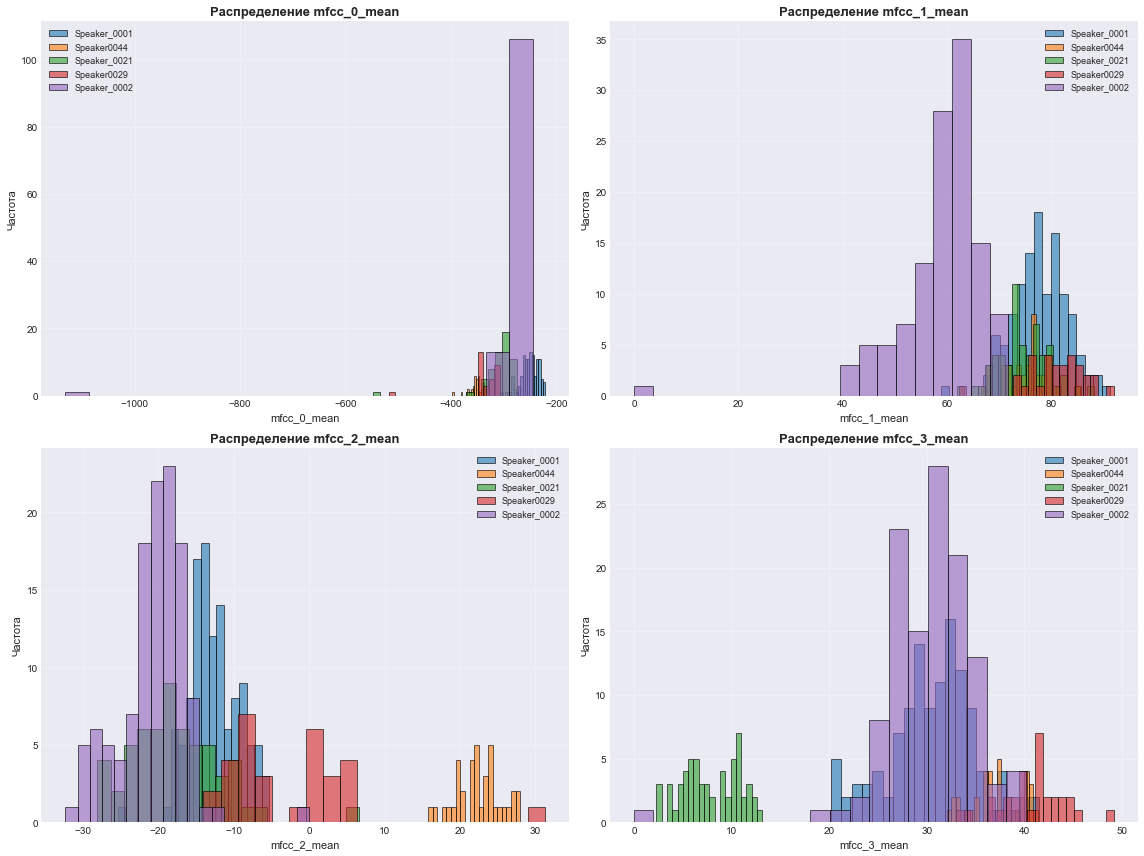

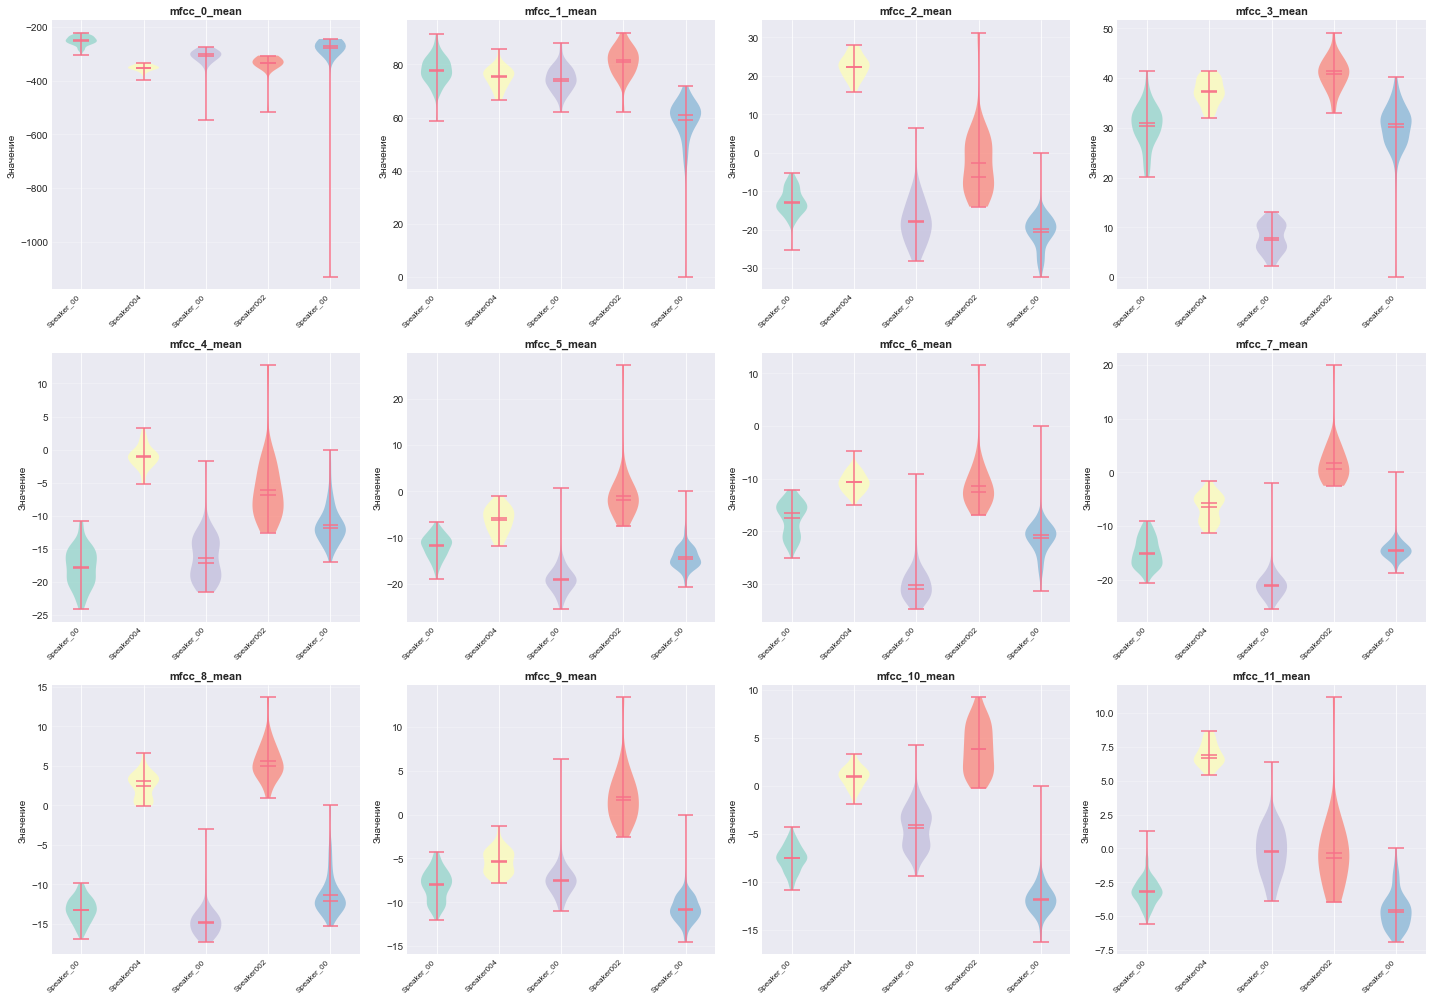

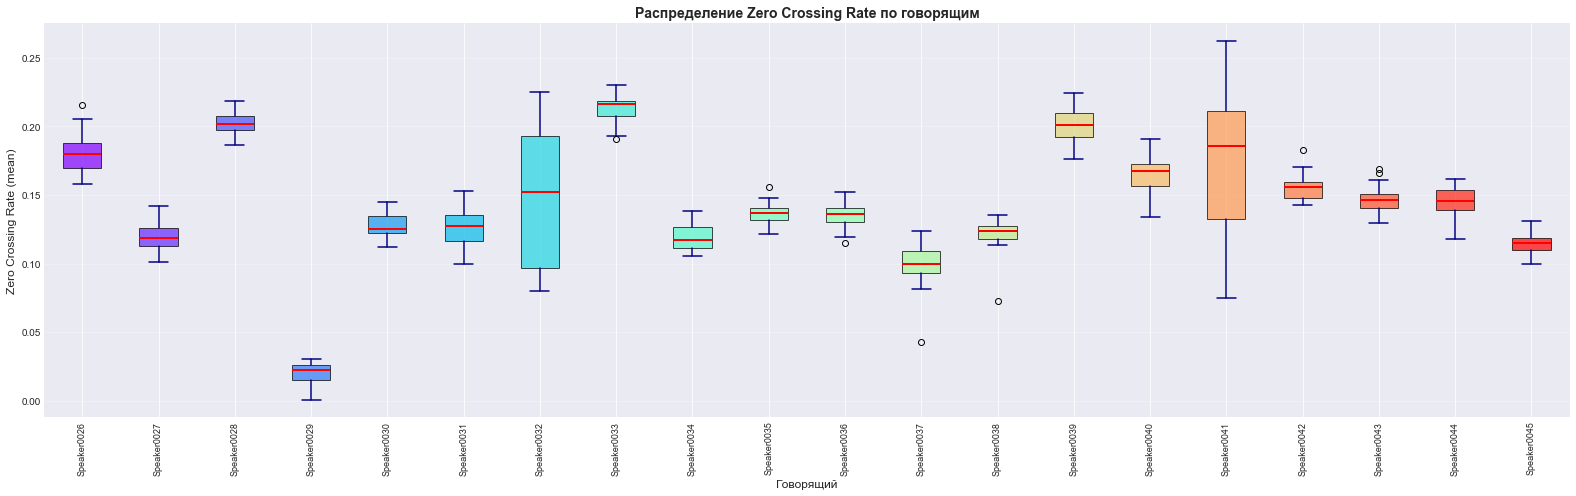

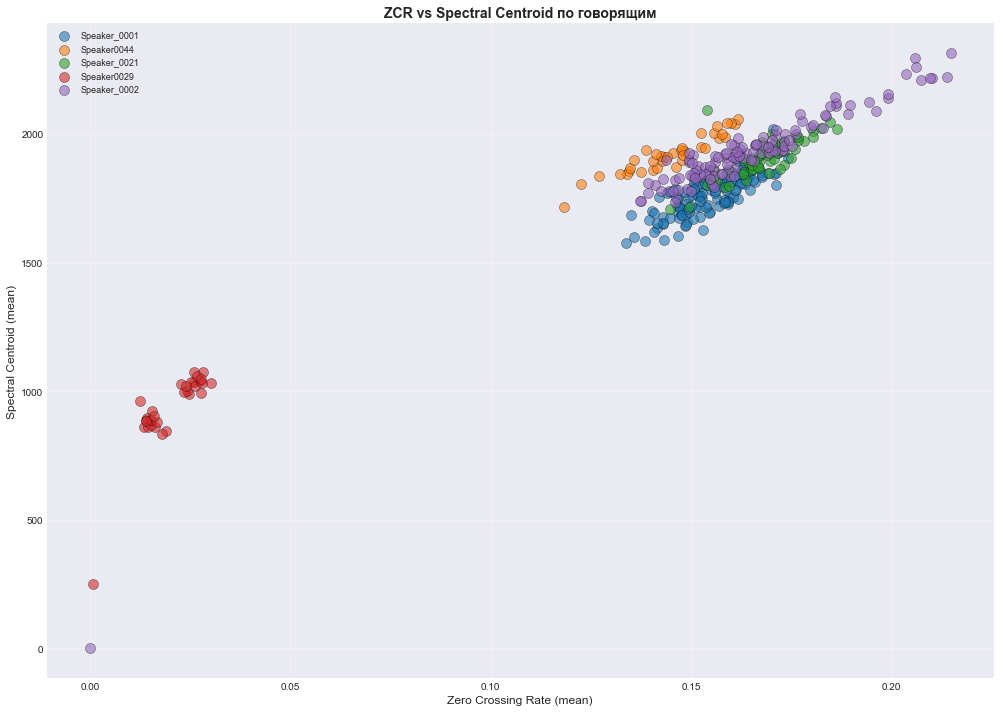


Создание heatmap MFCC по говорящим...


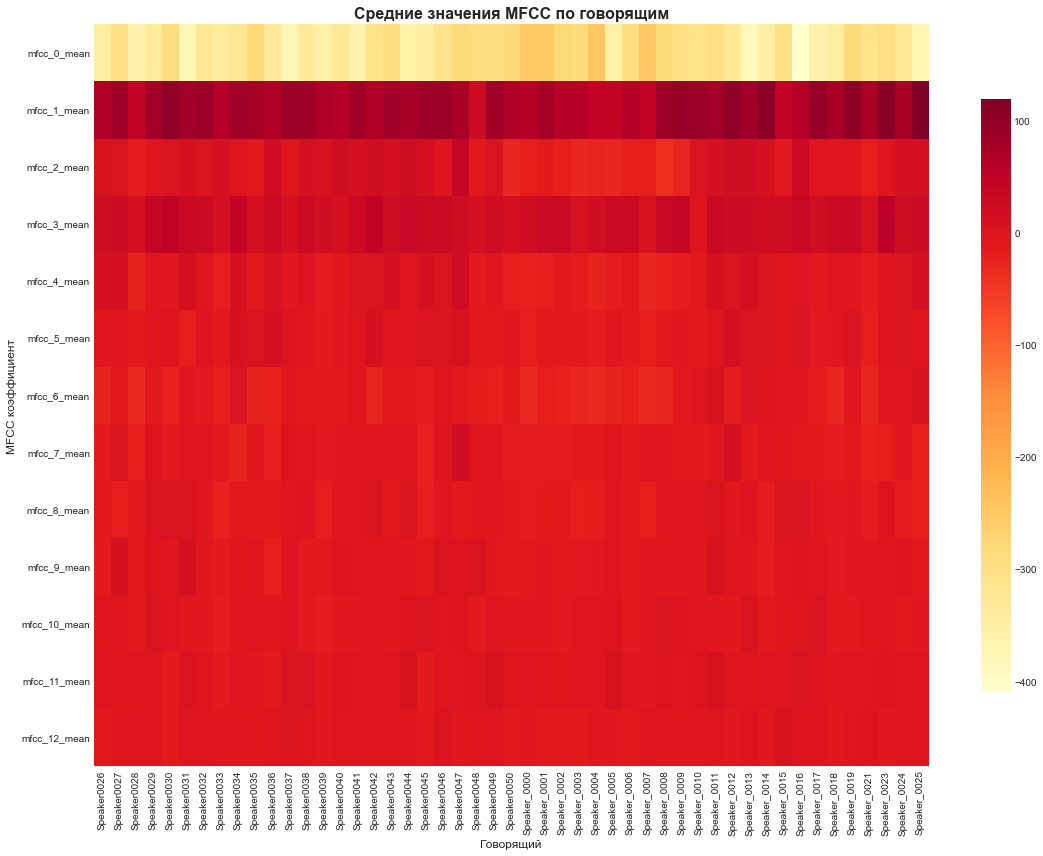

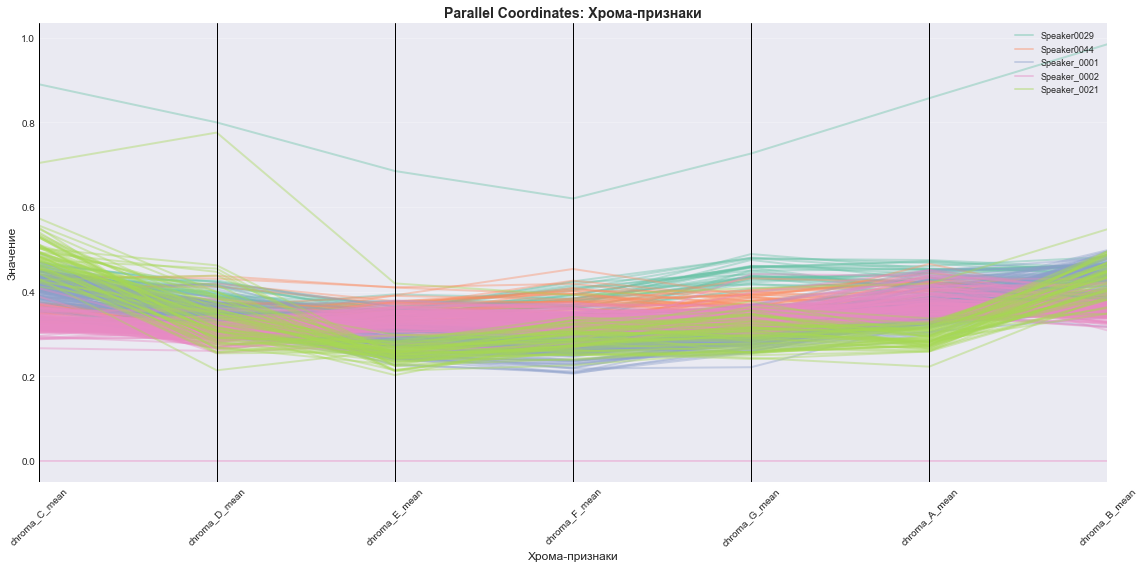


✓ Признаки сохранены в 'features_dataset.csv'
✓ Массивы numpy сохранены: features_X.npy, labels_y.npy
✓ Имена признаков сохранены: feature_names.txt

ЭТАП 2 ЗАВЕРШЕН: Извлечение признаков
✓ Извлечено записей: 2499
✓ Размерность признаков: (2499, 54)
✓ Уникальных говорящих: 49
✓ Графики сохранены в PNG (цветные)

Переходите к ноутбуку 03_model_training.ipynb


In [3]:
"""
KAGGLE NOTEBOOK 2: Извлечение признаков
Использует ваши оригинальные функции извлечения признаков
"""

import numpy as np
import pandas as pd
import librosa
import librosa.display
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Цветовая палитра
sns.set_palette("husl")
plt.style.use('seaborn-v0_8-darkgrid')

# ============================================================================
# 1. ЗАГРУЗКА ОТФИЛЬТРОВАННЫХ ДАННЫХ
# ============================================================================


df_filtered = pd.read_csv(r'D:\VKR\filtered_dataset.csv')
print(f"Загружено файлов: {len(df_filtered)}")
print(f"Уникальных говорящих: {df_filtered['speaker_id'].nunique()}")

# ============================================================================
# 2. ВАШИ ОРИГИНАЛЬНЫЕ ФУНКЦИИ ИЗВЛЕЧЕНИЯ ПРИЗНАКОВ
# ============================================================================

def extract_features(file_path, sr=16000):
    """
    ВАША ОРИГИНАЛЬНАЯ ФУНКЦИЯ
    Извлекает 54 признака из аудиофайла
    """
    try:
        # Загрузка аудио
        y, sr = librosa.load(file_path, sr=sr)
        
        # Убираем тишину
        y, _ = librosa.effects.trim(y, top_db=20)
        
        # MFCC (Mel-Frequency Cepstral Coefficients)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)
        
        # Chroma features
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)
        chroma_std = np.std(chroma, axis=1)
        
        # Zero Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(y)
        zcr_mean = np.mean(zcr)
        zcr_std = np.std(zcr)
        
        # Spectral Centroid
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        sc_mean = np.mean(spectral_centroid)
        sc_std = np.std(spectral_centroid)
        
        # Объединяем все признаки
        features = np.concatenate([
            mfcc_mean, mfcc_std,      # 26
            chroma_mean, chroma_std,  # 24
            [zcr_mean, zcr_std],      # 2
            [sc_mean, sc_std]         # 2
        ])
        
        return features
        
    except Exception as e:
        print(f"Ошибка при обработке {file_path}: {e}")
        return None

def create_feature_names():
    """ВАША ОРИГИНАЛЬНАЯ ФУНКЦИЯ создания имен признаков"""
    names = []
    
    # MFCC
    for i in range(13):
        names.append(f'mfcc_{i}_mean')
    for i in range(13):
        names.append(f'mfcc_{i}_std')
    
    # Chroma
    chroma_notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    for note in chroma_notes:
        names.append(f'chroma_{note}_mean')
    for note in chroma_notes:
        names.append(f'chroma_{note}_std')
    
    # ZCR и Spectral Centroid
    names.extend(['zcr_mean', 'zcr_std', 'spectral_centroid_mean', 'spectral_centroid_std'])
    
    return names

# ============================================================================
# 3. ИЗВЛЕЧЕНИЕ ПРИЗНАКОВ ИЗ ВСЕХ ФАЙЛОВ
# ============================================================================

print("\nИзвлечение признаков из аудиофайлов...")

features_list = []
labels_list = []
file_paths = []

for idx, row in tqdm(df_filtered.iterrows(), total=len(df_filtered)):
    features = extract_features(row['file_path'])
    
    if features is not None:
        features_list.append(features)
        labels_list.append(row['speaker_id'])
        file_paths.append(row['file_path'])

X = np.array(features_list)
y = np.array(labels_list)

print(f"\nИзвлечено признаков: {X.shape}")
print(f"Количество записей: {len(y)}")
print(f"Уникальных говорящих: {len(np.unique(y))}")

# ============================================================================
# 4. СОЗДАНИЕ DATAFRAME С ПРИЗНАКАМИ
# ============================================================================

feature_names = create_feature_names()
df_features = pd.DataFrame(X, columns=feature_names)
df_features['speaker_id'] = y
df_features['file_path'] = file_paths

print("\nПримеры извлеченных признаков:")
print(df_features.head())

print("\nСтатистика по признакам:")
print(df_features[feature_names].describe())

# ============================================================================
# 5. ВАША ВИЗУАЛИЗАЦИЯ: Корреляционная матрица - ЦВЕТНАЯ
# ============================================================================

# Корреляция первых 20 признаков
plt.figure(figsize=(22, 18))
correlation = df_features[feature_names[:20]].corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, mask=mask, annot=True, fmt='.2f', cmap='RdYlGn', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            annot_kws={'size': 8})
plt.title('Корреляционная матрица признаков (первые 20)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('feature_correlation_colored.png', dpi=300, bbox_inches='tight')
plt.show()

# ДОПОЛНИТЕЛЬНО: Полная корреляционная матрица без аннотаций
plt.figure(figsize=(20, 16))
correlation_full = df_features[feature_names].corr()
sns.heatmap(correlation_full, cmap='coolwarm', center=0, square=True, 
            linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Полная корреляционная матрица всех 54 признаков', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('feature_correlation_full_colored.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 6. ВАША ВИЗУАЛИЗАЦИЯ: Распределение MFCC - ЦВЕТНОЕ
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
colors = ['coral', 'lightblue', 'lightgreen', 'plum']

sample_speakers = np.random.choice(df_features['speaker_id'].unique(), 5, replace=False)

for i, ax in enumerate(axes.flat):
    feature = f'mfcc_{i}_mean'
    
    for idx, speaker in enumerate(sample_speakers):
        speaker_data = df_features[df_features['speaker_id'] == speaker][feature]
        color = plt.cm.tab10(idx)
        ax.hist(speaker_data, alpha=0.6, label=speaker, bins=20, color=color, edgecolor='black')
    
    ax.set_xlabel(feature, fontsize=11)
    ax.set_ylabel('Частота', fontsize=11)
    ax.legend(fontsize=9)
    ax.set_title(f'Распределение {feature}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('mfcc_distribution_colored.png', dpi=300, bbox_inches='tight')
plt.show()

# ДОПОЛНИТЕЛЬНО: Violin plot для MFCC
fig, axes = plt.subplots(3, 4, figsize=(20, 14))
axes = axes.flatten()

for i in range(12):
    feature = f'mfcc_{i}_mean'
    sample_data = df_features[df_features['speaker_id'].isin(sample_speakers)]
    
    parts = axes[i].violinplot([sample_data[sample_data['speaker_id'] == spk][feature].values 
                                 for spk in sample_speakers],
                                showmeans=True, showmedians=True)
    
    # Цветные violin plots
    for idx, pc in enumerate(parts['bodies']):
        pc.set_facecolor(plt.cm.Set3(idx))
        pc.set_alpha(0.7)
    
    axes[i].set_ylabel('Значение', fontsize=10)
    axes[i].set_title(f'{feature}', fontsize=11, fontweight='bold')
    axes[i].set_xticks(range(1, len(sample_speakers) + 1))
    axes[i].set_xticklabels([s[:10] for s in sample_speakers], rotation=45, ha='right', fontsize=8)
    axes[i].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('mfcc_violin_colored.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 7. ВАША ВИЗУАЛИЗАЦИЯ: ZCR Boxplot - ЦВЕТНОЙ
# ============================================================================

plt.figure(figsize=(22, 7))
sample_speakers_zcr = df_features['speaker_id'].unique()[:20]
df_sample = df_features[df_features['speaker_id'].isin(sample_speakers_zcr)]

# Создаем цветной boxplot
bp = plt.boxplot([df_sample[df_sample['speaker_id'] == spk]['zcr_mean'].values 
                   for spk in sample_speakers_zcr],
                  labels=sample_speakers_zcr,
                  patch_artist=True,
                  medianprops=dict(color='red', linewidth=2),
                  whiskerprops=dict(color='navy', linewidth=1.5),
                  capprops=dict(color='navy', linewidth=1.5))

# Раскрашиваем боксы
colors_bp = plt.cm.rainbow(np.linspace(0, 1, len(sample_speakers_zcr)))
for patch, color in zip(bp['boxes'], colors_bp):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.xlabel('Говорящий', fontsize=12)
plt.ylabel('Zero Crossing Rate (mean)', fontsize=12)
plt.title('Распределение Zero Crossing Rate по говорящим', fontsize=14, fontweight='bold')
plt.xticks(rotation=90, fontsize=9)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('zcr_boxplot_colored.png', dpi=300, bbox_inches='tight')
plt.show()

# ДОПОЛНИТЕЛЬНО: Scatter plot ZCR vs Spectral Centroid
plt.figure(figsize=(14, 10))
for idx, speaker in enumerate(sample_speakers):
    speaker_data = df_features[df_features['speaker_id'] == speaker]
    color = plt.cm.tab10(idx)
    plt.scatter(speaker_data['zcr_mean'], speaker_data['spectral_centroid_mean'],
               label=speaker, alpha=0.6, s=100, c=[color], edgecolors='black', linewidth=0.5)

plt.xlabel('Zero Crossing Rate (mean)', fontsize=12)
plt.ylabel('Spectral Centroid (mean)', fontsize=12)
plt.title('ZCR vs Spectral Centroid по говорящим', fontsize=14, fontweight='bold')
plt.legend(fontsize=9, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('zcr_vs_spectral_colored.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 8. ДОПОЛНИТЕЛЬНЫЕ ВИЗУАЛИЗАЦИИ
# ============================================================================

# Heatmap средних значений MFCC по говорящим
print("\nСоздание heatmap MFCC по говорящим...")
mfcc_cols = [f'mfcc_{i}_mean' for i in range(13)]
speaker_mfcc = df_features.groupby('speaker_id')[mfcc_cols].mean()

plt.figure(figsize=(16, 12))
sns.heatmap(speaker_mfcc.T, cmap='YlOrRd', annot=False, cbar_kws={"shrink": 0.8})
plt.title('Средние значения MFCC по говорящим', fontsize=16, fontweight='bold')
plt.xlabel('Говорящий', fontsize=12)
plt.ylabel('MFCC коэффициент', fontsize=12)
plt.tight_layout()
plt.savefig('mfcc_heatmap_speakers_colored.png', dpi=300, bbox_inches='tight')
plt.show()

# Parallel coordinates для хрома-признаков
from pandas.plotting import parallel_coordinates

chroma_cols = [f'chroma_{note}_mean' for note in ['C', 'D', 'E', 'F', 'G', 'A', 'B']]
sample_for_parallel = df_features[df_features['speaker_id'].isin(sample_speakers[:5])][chroma_cols + ['speaker_id']]

plt.figure(figsize=(16, 8))
parallel_coordinates(sample_for_parallel, 'speaker_id', 
                    color=plt.cm.Set2.colors[:5],
                    alpha=0.4, linewidth=2)
plt.title('Parallel Coordinates: Хрома-признаки', fontsize=14, fontweight='bold')
plt.xlabel('Хрома-признаки', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.xticks(rotation=45)
plt.legend(loc='best', fontsize=9)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('chroma_parallel_colored.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 9. СОХРАНЕНИЕ ДАННЫХ
# ============================================================================

# Сохраняем признаки в CSV
df_features.to_csv('features_dataset.csv', index=False)
print("\n✓ Признаки сохранены в 'features_dataset.csv'")

# Сохраняем отдельно X и y для моделей
np.save('features_X.npy', X)
np.save('labels_y.npy', y)
print("✓ Массивы numpy сохранены: features_X.npy, labels_y.npy")

# Сохраняем имена признаков
with open('feature_names.txt', 'w') as f:
    f.write('\n'.join(feature_names))
print("✓ Имена признаков сохранены: feature_names.txt")

print("\n" + "="*80)
print("ЭТАП 2 ЗАВЕРШЕН: Извлечение признаков")
print("="*80)
print(f"✓ Извлечено записей: {len(X)}")
print(f"✓ Размерность признаков: {X.shape}")
print(f"✓ Уникальных говорящих: {len(np.unique(y))}")
print(f"✓ Графики сохранены в PNG (цветные)")
print("\nПереходите к ноутбуку 03_model_training.ipynb")
print("="*80)